# Cafe Feedback Exploration & Walkthrough

This notebook captures the thinking, data processing steps, and exploratory visuals that underpin the Streamlit dashboard.

## Walkthrough & Process
- **Goal**: surface hard (ratings, spend) and soft (comments) signals for cafe locations, and deliver actionable insights.
- **Steps taken**: inspect raw schema -> normalise Location strings -> parse/clean ratings and currency -> coerce timestamps -> derive calendar fields -> profile distributions for each column -> build visuals.
- **Why this matters**: the raw file contains stray spaces in locations and timestamp-like strings in Transaction Value; without cleaning, filters and spend averages become misleading. Keeping cleaning documented here keeps the dashboard uncluttered.
- **How to refresh**: rerun this notebook on new drops; cleaned outputs and charts will stay in sync with the app.


## Quick explanation of data processing
- Drop empty Unnamed columns; coerce Rating to numeric.
- Strip/collapse whitespace in Location to merge duplicates (e.g., Albany  -> Albany).
- Parse Transaction Value as currency, strip $/commas, and discard impossible spends (<=0 or >) to remove timestamp artefacts.
- Parse Transaction Date and Time as day-first datetime; derive Date and DayName for trend views.
- Persist these steps so dashboard filters and aggregates stay realistic.


In [1]:
import re
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme()

DATA_FILE = Path("Sample data - Cafe - Sample data 2400 records.csv")
raw_df = pd.read_csv(DATA_FILE)
raw_df.head()

,Location,Rating,Comment,Transaction Date and Time,Transaction Value,feedback_id,Unnamed: 6,Unnamed: 7
0,Domain,5,"Awesome, friendly staff, they all are smiling ...",19/10/2024 6:03:00 AM,$19.50,4974583,NaN,NaN
1,Timaru,5,The service,19/10/2024 6:09:00 AM,$19.17,4974584,NaN,NaN
2,Upper Hutt,5,The staff are fabulous and neither is too much...,19/10/2024 6:13:00 AM,$10.60,4974586,NaN,NaN
3,Wellington central,4,More dairy + gluten free food options.,19/10/2024 6:21:00 AM,$4.00,4974587,NaN,NaN
4,Henderson,5,Friendly welcoming staff always smiling,19/10/2024 6:43:00 AM,$5.50,4974591,NaN,NaN


## Raw exploration before cleaning
- Visualise raw values first to spot anomalies that drive cleaning decisions.


In [2]:
# Raw distributions prior to cleaning
raw_location_counts = raw_df["Location"].value_counts()
print("Locations")
display(raw_location_counts)

# Duplicate locations due to extra spaces
normalized_locations = raw_df.assign(
    NormalizedLocation=raw_df["Location"].astype(str).str.strip()
)
dup_location_table = (
    normalized_locations.groupby("NormalizedLocation", dropna=False)
    .agg(
        sample_raw=("Location", "first"),
        occurrences=("Location", "size"),
        unique_raw_variants=("Location", "nunique"),
    )
    .reset_index()
    .rename(
        columns={
            "NormalizedLocation": "Location (duplicate)",
            "sample_raw": "Raw location sample",
            "occurrences": "Occurrences",
            "unique_raw_variants": "Unique raw variants",
        }
    )
)
dup_location_table = (
    dup_location_table[dup_location_table["Unique raw variants"] > 1]
    .sort_values("Occurrences", ascending=False)
    .drop(columns="Unique raw variants")
)
print("\nDuplicated location table:")
display(dup_location_table)

# Transaction Value: non-currency patterns
raw_txn_strings = raw_df["Transaction Value"]
print("\nExamples of transaction values containing non-currency patterns:")
display(raw_txn_strings[raw_txn_strings.str.contains("/", na=True)])

# Transaction Value: numeric outliers
raw_txn_numeric = pd.to_numeric(
    raw_txn_strings.str.replace("[^0-9.]", "", regex=True), errors="coerce"
)
anomaly_upper_threshold = 500
anomaly_lower_threshold = 0
anomalies = raw_txn_numeric[
    (raw_txn_numeric > anomaly_upper_threshold) | (raw_txn_numeric <= anomaly_lower_threshold)
].sort_values(ascending=False)
print(f"{len(anomalies)} raw transaction values are outside the expected range [0, {anomaly_upper_threshold}]")
display(anomalies)


# Ratings: value counts and out-of-range/missing
rating_raw = raw_df['Rating']
print('Rating value counts (raw):')
display(rating_raw.value_counts(dropna=False))
rating_numeric = pd.to_numeric(rating_raw, errors='coerce')
rating_anomalies = rating_raw[(rating_numeric.isna()) | (rating_numeric < 1) | (rating_numeric > 5)]
print(f"{len(rating_anomalies)} ratings are missing or outside 1-5")
display(rating_anomalies)

# Transaction Date and Time: non-parsable examples
raw_dates = raw_df["Transaction Date and Time"]
standard_format = "%d/%m/%Y %I:%M:%S %p"
parsed_dates = pd.to_datetime(raw_dates, format=standard_format, errors="coerce")
bad_dates = raw_dates[parsed_dates.isna()]
print(f"{len(bad_dates)} transaction datetime values could not be parsed")
display(bad_dates)

# feedback_id: blanks, non-numeric, duplicates
feedback_raw = raw_df['feedback_id'].astype(str).str.strip()
bad_feedback = feedback_raw[(feedback_raw == '') | (~feedback_raw.str.match(r'^\d+$'))]
print(f"{len(bad_feedback)} feedback_id values are non-numeric")
display(bad_feedback)
dup_feedback = feedback_raw[feedback_raw.duplicated(keep=False)]
print(f"{len(dup_feedback)} feedback_id values are duplicates")
display(dup_feedback)

# Blank unnamed columns
cols_to_display = raw_df.columns[6:9]
print(f"Inspecting columns (6th & 7th): {cols_to_display.tolist()}")
preview_cols = (
    raw_df[cols_to_display]
    .astype("object")
    .sort_values(by=cols_to_display.tolist(), ascending=False)
    .head(10)
)
display(preview_cols)

Locations


Location
Wanganui           54
Rangiora           51
Palmerston Nth     48
Palmerston Nth     47
Kapiti             47
                   ..
Whakatane          15
Henderson          12
Pukekohe           11
Lincoln Road        7
Queen Street        2
Name: count, Length: 75, dtype: int64


Duplicated location table:


,Location (duplicate),Raw location sample,Occurrences
40,Palmerston Nth,Palmerston Nth,95
22,Invercargill,Invercargill,77
34,Nelson,Nelson,77
5,Botany,Botany,63
51,Rotorua,Rotorua,60
0,Albany,Albany,55
44,Pukekohe,Pukekohe,49
20,Henderson,Henderson,38



Examples of transaction values containing non-currency patterns:


509    20/10/2020 8:24:00 AM
Name: Transaction Value, dtype: object

92 raw transaction values are outside the expected range [0, 500]


509     2.010202e+12
2362    2.410201e+11
1986    2.310201e+11
1556    2.210201e+11
1249    2.210201e+11
            ...     
2269    0.000000e+00
2293    0.000000e+00
2340    0.000000e+00
2367    0.000000e+00
2393    0.000000e+00
Name: Transaction Value, Length: 92, dtype: float64

Rating value counts (raw):


Rating
5    1980
4     335
3      68
2      16
1       8
Name: count, dtype: int64

0 ratings are missing or outside 1-5


Series([], Name: Rating, dtype: int64)

5 transaction datetime values could not be parsed


509                         WEB
1249    kim.wise@auckland.ac.nz
1556        robsued47@gmail.com
1986         tkmolloy@gmail.com
2362          lynn.m@xtra.co.nz
Name: Transaction Date and Time, dtype: object

5 feedback_id values are non-numeric


509        16.1
1249    WJZPJCF
1556    NFTUTGH
1986    MTKPDCF
2362    MFFPYCF
Name: feedback_id, dtype: object

0 feedback_id values are duplicates


Series([], Name: feedback_id, dtype: object)

Inspecting columns (6th & 7th): ['Unnamed: 6', 'Unnamed: 7']


,Unnamed: 6,Unnamed: 7
509,DEPLHCF,4975742.0
2362,4979455,NaN
1986,4978775,NaN
1556,4977933,NaN
1249,4977334,NaN
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


**Raw-data findings:**
- Locations appear multiple times due to extra space (e.g., Albany vs Albany ).
- Transaction Value includes timestamp-like strings (e.g., 20/10/2020 8:24:00 AM) and extreme magnitudes (e.g., 241020120707.0) that would inflate spend if unfiltered.
- Transaction Date and Time has entries that are not datetime.
- feedback_id includes non-numeric strings that should be cleaned.
- 2 unnamed columns are almost entirely blank and can be removed.
- These observed issues motivate the cleaning rules applied below.

In [ ]:
# Cleaning helpers
def parse_transaction(val):
    if pd.isna(val):
        return None
    s = str(val).strip()
    m = re.search(r"-?\$?\s*([0-9]{1,3}(?:,[0-9]{3})*|[0-9]+)(?:\.[0-9]{1,2})?", s)
    if not m:
        return None
    try:
        v = float(re.sub(r"[,$]", "", m.group()))
    except ValueError:
        return None
    if v <= 0 or v > 500:
        return None
    return v

df = raw_df.copy()
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
df["Location"] = df["Location"].astype(str).str.strip().str.replace(r"\s+", " ", regex=True)
df["Rating"] = pd.to_numeric(df["Rating"], errors="coerce")
df["Transaction Value"] = df["Transaction Value"].apply(parse_transaction)
df["Transaction Date and Time"] = pd.to_datetime(df["Transaction Date and Time"], dayfirst=True, errors="coerce")
df["Date"] = df["Transaction Date and Time"].dt.date
df["DayName"] = df["Transaction Date and Time"].dt.day_name()
df.dropna(subset=["Rating", "Transaction Value"], inplace=True)
df.head()

,Location,Rating,Comment,Transaction Date and Time,Transaction Value,feedback_id,Date,DayName
0,Domain,5,"Awesome, friendly staff, they all are smiling ...",2024-10-19 06:03:00,19.50,4974583,2024-10-19,Saturday
1,Timaru,5,The service,2024-10-19 06:09:00,19.17,4974584,2024-10-19,Saturday
2,Upper Hutt,5,The staff are fabulous and neither is too much...,2024-10-19 06:13:00,10.60,4974586,2024-10-19,Saturday
3,Wellington central,4,More dairy + gluten free food options.,2024-10-19 06:21:00,4.00,4974587,2024-10-19,Saturday
4,Henderson,5,Friendly welcoming staff always smiling,2024-10-19 06:43:00,5.50,4974591,2024-10-19,Saturday


## Categorical distributions (all categories printed)
For each categorical-like column, the full value counts are displayed. Plots are shown when the category count is manageable.


==== Location (categorical-like) ====


Location
Palmerston Nth    92
Invercargill      76
Nelson            75
Botany            62
Rotorua           59
                  ..
Williams Drive    16
Rosebank Road     15
Whakatane         14
Lincoln Road       7
Queen Street       1
Name: count, Length: 67, dtype: int64


==== Comment (categorical-like) ====


Comment
Great service                                                                                                                                                                                             14
Friendly staff                                                                                                                                                                                            13
Good service                                                                                                                                                                                               9
Service                                                                                                                                                                                                    8
Friendly service                                                                                                                                                            


==== Transaction Date and Time (categorical-like) ====


Transaction Date and Time
2024-10-24 09:28:00    7
2024-10-21 10:09:00    6
2024-10-21 09:27:00    6
2024-10-19 09:44:00    6
2024-10-19 08:50:00    6
                      ..
2024-10-19 08:02:00    1
2024-10-19 07:39:01    1
2024-10-19 06:53:00    1
2024-10-24 11:30:00    1
2024-10-24 10:05:00    1
Name: count, Length: 1436, dtype: int64


==== feedback_id (categorical-like) ====


feedback_id
4979626    1
4974583    1
4974584    1
4974586    1
4974587    1
          ..
4974621    1
4974622    1
4974623    1
4974625    1
4974626    1
Name: count, Length: 2316, dtype: int64


==== Date (categorical-like) ====


Date
2024-10-20    434
2024-10-19    409
2024-10-21    400
2024-10-23    378
2024-10-22    364
2024-10-24    330
<missing>       1
Name: count, dtype: int64

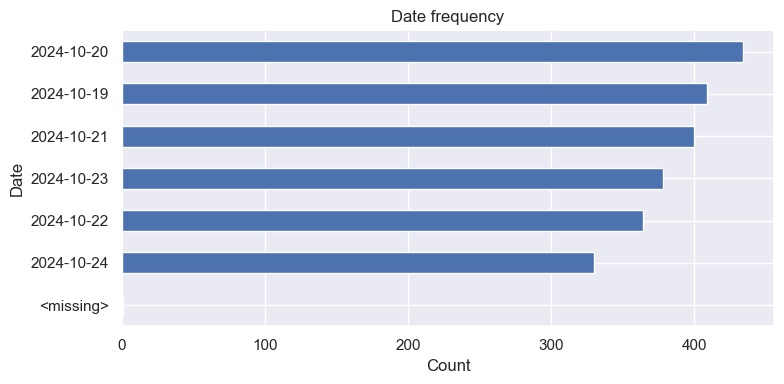


==== DayName (categorical-like) ====


DayName
Sunday       434
Saturday     409
Monday       400
Wednesday    378
Tuesday      364
Thursday     330
<missing>      1
Name: count, dtype: int64

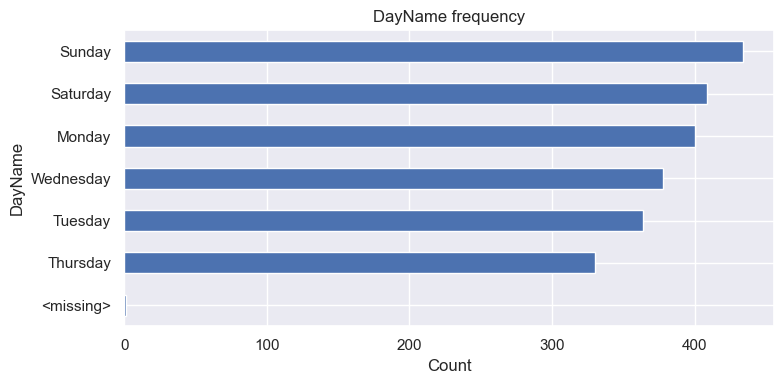

In [4]:
categorical_cols = []
numeric_cols = []

for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        numeric_cols.append(col)
    elif pd.api.types.is_datetime64_any_dtype(df[col]):
        categorical_cols.append(col)
    else:
        categorical_cols.append(col)

for col in categorical_cols:
    print(f"\n==== {col} (categorical-like) ====")
    vc = df[col].fillna("<missing>").value_counts()
    display(vc)
    if 1 < len(vc) <= 30:
        vc.sort_values().plot(kind="barh", title=f"{col} frequency", figsize=(8, max(4, len(vc) * 0.25)))
        plt.xlabel("Count")
        plt.tight_layout()
        plt.show()

## Numeric distributions
Descriptive stats and histograms for each numeric-like column.


==== Rating (numeric-like) ====


count    2316.000000
mean        4.779793
std         0.543445
min         1.000000
25%         5.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: Rating, dtype: float64

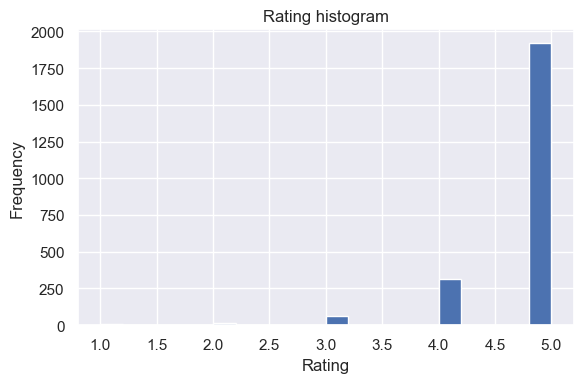


==== Transaction Value (numeric-like) ====


count    2316.000000
mean       15.967414
std        12.962577
min         0.500000
25%         6.800000
50%        11.500000
75%        20.000000
max       102.000000
Name: Transaction Value, dtype: float64

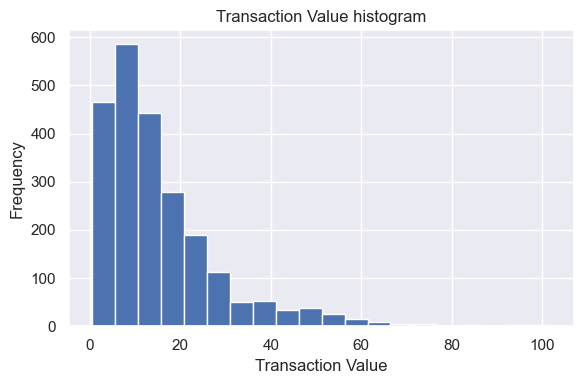

In [5]:
for col in numeric_cols:
    print(f"\n==== {col} (numeric-like) ====")
    series = df[col].dropna()
    display(series.describe())
    series.plot(kind="hist", bins=20, title=f"{col} histogram", figsize=(6,4))
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

## Targeted visuals
- Rating distribution and average transaction by rating
- Daily trends of rating and spend (to mirror the dashboard)
- Top comment keywords

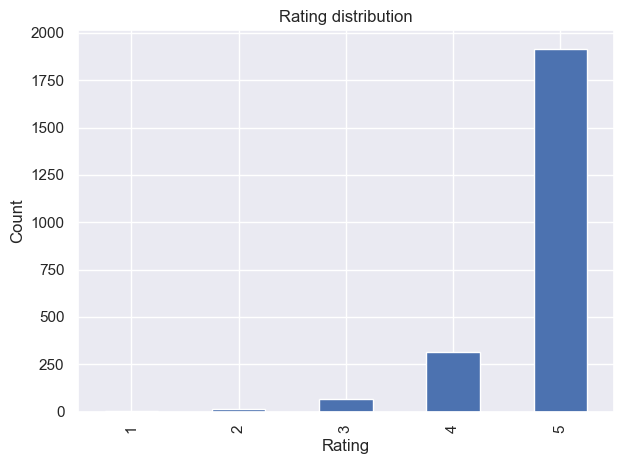

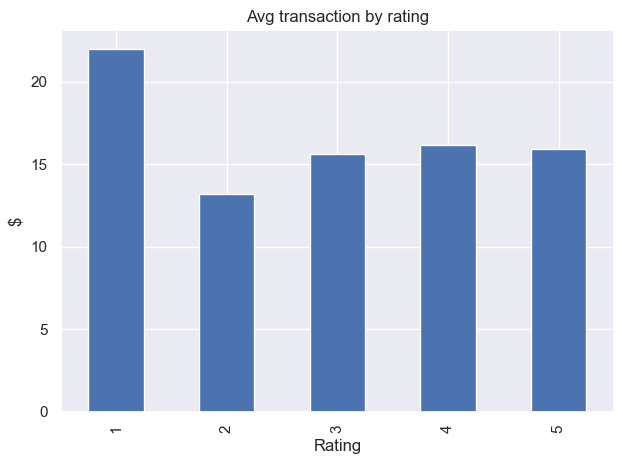

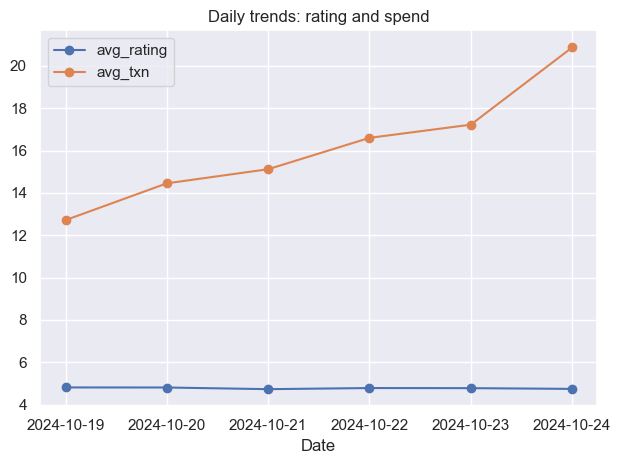

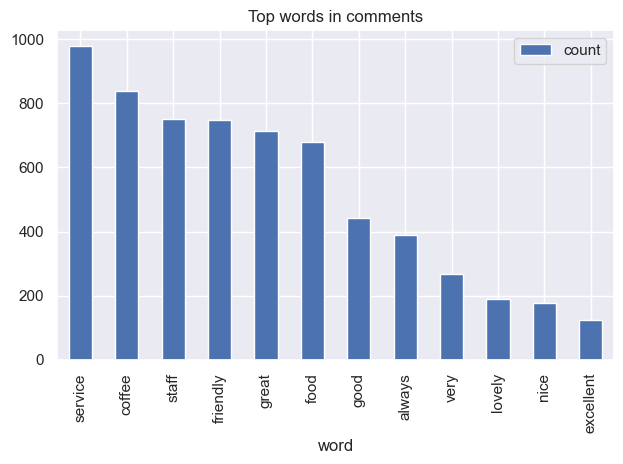

In [6]:
rating_counts = df["Rating"].value_counts().sort_index()
rating_counts.plot(kind="bar", title="Rating distribution", ylabel="Count", xlabel="Rating")
plt.tight_layout()
plt.show()

avg_txn_by_rating = df.groupby("Rating")["Transaction Value"].mean()
avg_txn_by_rating.plot(kind="bar", title="Avg transaction by rating", ylabel="$", xlabel="Rating")
plt.tight_layout()
plt.show()

daily = (
    df.groupby("Date")
    .agg(avg_rating=("Rating", "mean"), avg_txn=("Transaction Value", "mean"))
    .sort_index()
)
daily.plot(y=["avg_rating", "avg_txn"], title="Daily trends: rating and spend", marker="o")
plt.tight_layout()
plt.show()

stop_words = {"the","and","to","of","a","in","for","with","is","it","on","my","our","at","are","was","be","have","has","that","they","this","i","we","you","their","as","so","its","by","from","an","were","your","also","us","had"}
word_counts = {}
for c in df["Comment"].dropna().astype(str):
    for w in re.findall(r"[a-zA-Z']+", c.lower()):
        if w not in stop_words and len(w) > 1:
            word_counts[w] = word_counts.get(w, 0) + 1
top_words = sorted(word_counts.items(), key=lambda kv: kv[1], reverse=True)[:12]
pd.DataFrame(top_words, columns=["word", "count"]).set_index("word").plot(kind="bar", title="Top words in comments")
plt.tight_layout()
plt.show()

## Key summaries
- Location labels need normalisation; otherwise filters show duplicates.
- Cleaning transaction values removes timestamp artefacts and keeps spend realistic (~$15 median).
- Ratings skew high while low ratings are scarce; focus on consistency and speed where comments flag issues.
- Daily trend views help spot emerging changes faster than monthly rolls.

## Word Cloud Visualization
- Visualise the most frequent words in the comments using a word cloud to get a quick sense of the feedback themes.

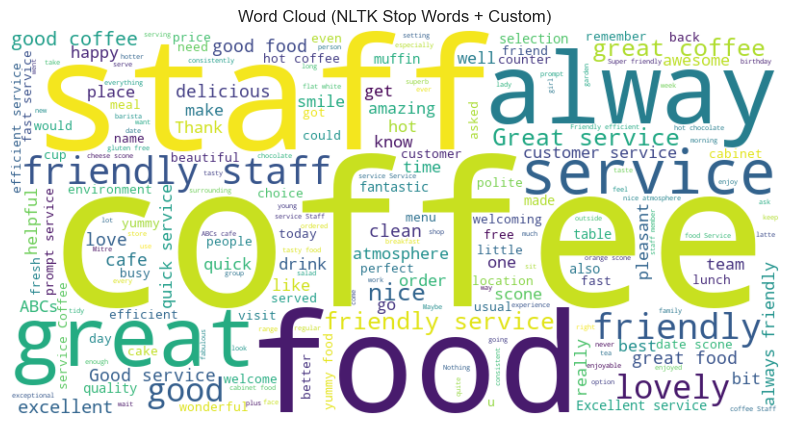

In [11]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords if not already present
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Combine all comments into a single string
text = " ".join(comment for comment in df["Comment"].dropna().astype(str))

# Best Practice: Use NLTK's list + Domain Specific
# NLTK is widely considered the "gold standard" for general English stop words in data science.
# It is more linguistically rigorous than the simple list in wordcloud.
nltk_stopwords = set(stopwords.words('english'))

# Add domain-specific noise words
custom_stopwords = nltk_stopwords.union(["coffee", "cafe", "place", "shop", "drink"])

# Generate the word cloud using the NLTK-based set
wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=nltk_stopwords).generate(text)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud (NLTK Stop Words + Custom)")
plt.show()